In [1]:
# Activate TF2 behavior:
from tensorflow.python import tf2
if not tf2.enabled():
  import tensorflow.compat.v2 as tf
  tf.enable_v2_behavior() 
  assert tf2.enabled()

import numpy as np
import tensorflow as tf

# Set seeds
np.random.seed(10)
tf.random.set_seed(10)

from tensorflow.keras.layers import Input, Dense, LSTM, Lambda, Dropout, Flatten, Reshape, Conv2DTranspose
from tensorflow.keras.layers import Conv2D, UpSampling2D, MaxPooling2D, Conv3D, MaxPool3D, UpSampling3D, Conv3DTranspose

from tensorflow.keras import optimizers, models, regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model, Sequential, Model
from tensorflow.keras.regularizers import l1
from tensorflow.keras.utils import plot_model
from keras.losses import mse, binary_crossentropy

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler


# import matplotlib
# matplotlib.use('Agg')

import matplotlib.pyplot as plt

mode = 'train'   
# mode = 'test'

physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

import umap
import time
time1 = time.time()

Num GPUs: 8


In [2]:
# import numpy as np; np.__version__

In [3]:
######## folder is where parameter matrix is stored ######

def shuffle(X, y):
    shuffleOrder = np.arange(X.shape[0])
    np.random.shuffle(shuffleOrder)
    X = X[shuffleOrder]
    y = y[shuffleOrder]
    return X, y, shuffleOrder

In [4]:
num_epochs = 100
batch_size = 2 #4 #256
learning_rate = 1e-4 #1e-4
decay_rate = 1.0

latent_dim = 8 #16 ###
epsilon_mean = 0.1
epsilon_std = 1e-4 #1e-4

nGrid= 128
nSamples = 1000

train_test_split= 0.90
from sklearn.utils import shuffle

In [5]:

def load_data(nSamples):
    
    dirIn = '/lcrc/project/cosmo_ai/nramachandra/Projects/PRISM/ellipsoidal_void/data/'

    temp_data = np.load(dirIn + 'random_ellipsoids_3d.npy')[:nSamples]
    radii_data = np.load(dirIn + 'random_ellipsoids_3d_radii.npy')[:nSamples]


    split = np.int(train_test_split*temp_data.shape[0])

    train_data = temp_data[0:split, :, :, :].astype('float32')
    train_target = radii_data[0:split, :].astype('float32')
    test_data = temp_data[split:, :, :, :].astype('float32')
    test_target = radii_data[split:, :].astype('float32')

    return (train_data[:, :nGrid, :nGrid, :nGrid], train_target), (test_data[:, :nGrid, :nGrid, :nGrid], test_target)
            


In [6]:
(train_images, train_radii), (test_images, test_radii) = load_data(nSamples)

print(train_images.shape)
print(test_images.shape)

# # RESCALING IMAGES
# #print(train_images[0,:,:,:,0])
# tmin = train_images.min()
# tmax = train_images.max()
# print(tmin, tmax)
# train_images = (train_images - tmin) / (tmax - tmin) # Normalize the images to [-1, 1]
# test_images = (test_images - tmin) / (tmax - tmin)
# print(train_images.min(), train_images.max())   

/tmp/ipykernel_789146/2413570872.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  split = np.int(train_test_split*temp_data.shape[0])


(900, 128, 128, 128)
(100, 128, 128, 128)


In [7]:
loaddata = 'average' ## 'average' or 'log' for different normalization


if loaddata == 'average':
# RESCALING IMAGES
#print(train_images[0,:,:,:,0])
    tmin = train_images.min()
    tmax = train_images.max()
    print('old min-max:', tmin, tmax)
    train_images = (train_images - tmin) / (tmax - tmin) # Normalize the images to [-1, 1]
    test_images = (test_images - tmin) / (tmax - tmin)
    print('new min-max:', train_images.min(), train_images.max())

    shape0 = train_images.shape[0]
    swe_train_data = train_images.reshape(shape0, nGrid, nGrid, nGrid, 1)

if loaddata == 'log':
    shape0 = train_images.shape[0]
    train_images = train_images + data_offset
    swe_train_data = np.log10(train_images)
    swe_train_data = swe_train_data.reshape(shape0, nGrid, nGrid, nGrid)
    preproc = Pipeline([('stdscaler', StandardScaler())])
    #swe_data_shuffle, indx_shuffle, shuffle_order  = shuffle(swe_data, temp_indx)
    swe_data_shuffle = shuffle(swe_train_data)

    swe_train_data = preproc.fit_transform(swe_data_shuffle.reshape(-1,1))
    swe_train_data = swe_train_data.reshape(shape0, nGrid, nGrid, nGrid, 1)
    #swe_train_data = np.copy(swe_train)
    print('swe_data max is :')
    print(np.max(swe_train_data))
    print('swe_data min is :')
    print(np.min(swe_train_data))
    print('over')

old min-max: 0.0 1.0
new min-max: 0.0 1.0


In [8]:
@tf.function
def custom_loss(encoder_inputs,ae_outputs,z_log_var,z_mean ):
    reconstruction_loss = mse(K.flatten(encoder_inputs), K.flatten(ae_outputs))
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss) #, axis=-1)   ### replace sum with mean
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + beta*kl_loss)
    tf.print("kl_loss= ")
    tf.print(kl_loss)
    tf.print("   recons_loss= ")
    tf.print(reconstruction_loss)

    return vae_loss

@tf.function
def recons_loss(encoder_inputs,ae_outputs):
    reconstruction_loss = mse(K.flatten(encoder_inputs), K.flatten(ae_outputs))
    return reconstruction_loss

# @tf.function
# def kl_loss(y_true, y_pred):
#     kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
#     kl_loss = K.sum(kl_loss, axis=-1)
#     kl_loss *= -0.5
#     return kl_loss        

# @tf.function
# def sampling(args):
#     z_mean, z_log_var = args
#     batch = K.shape(z_mean)[0]
#     dim = K.int_shape(z_mean)[1]
# #    epsilon = K.random_normal(shape=(batch,dim), mean=epsilon_mean, stddev=epsilon_std)
# #    return z_mean + K.exp(0.5*z_log_var) * epsilon
#     epsilon = K.random_normal(shape=(batch,dim))
#     return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [9]:
'''
###### Encoder ###################
encoder_inputs = Input(shape=(nGrid, nGrid, nGrid,1),name='Field')
x= Conv3D(128, kernel_size= (3,3,3), activation='relu', padding='same')(encoder_inputs)
# x= Conv3D(64, kernel_size= (3,3,3), activation='relu', padding='same')(x)   ###### added back
x= Conv3D(64, kernel_size= (3,3,3), activation='relu', padding='same')(x)   ###### added back
x= Conv3D(64, kernel_size= (3,3,3), activation='relu', padding='same')(x)   ###### added back
x=MaxPool3D(pool_size=(2,2,2), padding='same')(x)

x= Conv3D(64,kernel_size=(3,3,3), activation='relu', padding='same')(x) ##### changed here
x= MaxPool3D(pool_size=(2,2,2),padding='same')(x)

x= Flatten()(x)
z_mean= Dense(latent_dim, name='z_mean')(x)
z_log_var= Dense(latent_dim, name='z_log_var')(x)

z = Lambda(sampling, output_shape=(latent_dim,), name='z')((z_mean, z_log_var))

# instantiate encoder model
#encoder = Model(encoder_inputs, z_mean, name='encoder')  ### common AE
encoder = Model(encoder_inputs, ( (z_mean, z_log_var, z) ), name='encoder')
encoder.summary()
'''

"\n###### Encoder ###################\nencoder_inputs = Input(shape=(nGrid, nGrid, nGrid,1),name='Field')\nx= Conv3D(128, kernel_size= (3,3,3), activation='relu', padding='same')(encoder_inputs)\n# x= Conv3D(64, kernel_size= (3,3,3), activation='relu', padding='same')(x)   ###### added back\nx= Conv3D(64, kernel_size= (3,3,3), activation='relu', padding='same')(x)   ###### added back\nx= Conv3D(64, kernel_size= (3,3,3), activation='relu', padding='same')(x)   ###### added back\nx=MaxPool3D(pool_size=(2,2,2), padding='same')(x)\n\nx= Conv3D(64,kernel_size=(3,3,3), activation='relu', padding='same')(x) ##### changed here\nx= MaxPool3D(pool_size=(2,2,2),padding='same')(x)\n\nx= Flatten()(x)\nz_mean= Dense(latent_dim, name='z_mean')(x)\nz_log_var= Dense(latent_dim, name='z_log_var')(x)\n\nz = Lambda(sampling, output_shape=(latent_dim,), name='z')((z_mean, z_log_var))\n\n# instantiate encoder model\n#encoder = Model(encoder_inputs, z_mean, name='encoder')  ### common AE\nencoder = Model(enc

In [10]:
'''
###### Decoder ################
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x= Dense(512)(latent_inputs)

x= Reshape((8,8,8,1))(x)

x= Conv3D(128, kernel_size=(3,3,3), activation='relu',padding='same')(x)  #### changed here
x= UpSampling3D(size=(2,2,2))(x)

x= Conv3D(64, kernel_size=(3,3,3), activation='relu',padding='same')(x)
x= UpSampling3D(size=(2,2,2))(x)

x= Conv3D(64, kernel_size=(3,3,3), activation='relu',padding='same')(x)
x= UpSampling3D(size=(2,2,2))(x)

#x= Conv3D(128, kernel_size=(3,3,3), activation='relu', padding='same')(x)
#x= Conv3D(64, kernel_size=(3,3,3), activation='relu', padding='same')(x)
x= Conv3D(64, kernel_size=(3,3,3), activation='relu',padding='same')(x)
x= UpSampling3D(size=(2,2,2))(x)

#x= Conv3D(128, kernel_size=(3,3,3), activation='relu',padding='same')(x)
#x= Conv3D(64, kernel_size=(3,3,3), activation='relu',padding='same')(x)


##x= Conv3D(64, kernel_size=(3,3,3), activation='relu',padding='same')(x) (0305 commented out)


##x= Conv3D(256, kernel_size=(1,1,1), activation='relu', padding='same')(x)   #### changed here ####
#x= Conv3D(512, kernel_size=(2,2,2), activation='relu', padding='same')(x)

# x= UpSampling3D(size=(2,2,2))(x)

decoded = Conv3D(1,kernel_size=(3,3,3), activation=None, padding='same')(x)
decoder = Model(inputs=latent_inputs, outputs=decoded)
decoder.summary()
'''

"\n###### Decoder ################\nlatent_inputs = Input(shape=(latent_dim,), name='z_sampling')\nx= Dense(512)(latent_inputs)\n\nx= Reshape((8,8,8,1))(x)\n\nx= Conv3D(128, kernel_size=(3,3,3), activation='relu',padding='same')(x)  #### changed here\nx= UpSampling3D(size=(2,2,2))(x)\n\nx= Conv3D(64, kernel_size=(3,3,3), activation='relu',padding='same')(x)\nx= UpSampling3D(size=(2,2,2))(x)\n\nx= Conv3D(64, kernel_size=(3,3,3), activation='relu',padding='same')(x)\nx= UpSampling3D(size=(2,2,2))(x)\n\n#x= Conv3D(128, kernel_size=(3,3,3), activation='relu', padding='same')(x)\n#x= Conv3D(64, kernel_size=(3,3,3), activation='relu', padding='same')(x)\nx= Conv3D(64, kernel_size=(3,3,3), activation='relu',padding='same')(x)\nx= UpSampling3D(size=(2,2,2))(x)\n\n#x= Conv3D(128, kernel_size=(3,3,3), activation='relu',padding='same')(x)\n#x= Conv3D(64, kernel_size=(3,3,3), activation='relu',padding='same')(x)\n\n\n##x= Conv3D(64, kernel_size=(3,3,3), activation='relu',padding='same')(x) (0305 c

In [11]:
###### Encoder ###################
encoder_inputs = Input(shape=(nGrid, nGrid, nGrid, 1),name='Field')
x= Conv3D(128, kernel_size=3, activation='relu', padding='same')(encoder_inputs)
x= Conv3D(64, kernel_size=3, strides=4, activation='relu', padding='same')(x)   ###### added back
x= Conv3D(64, kernel_size=3, strides=2, activation='relu', padding='same')(x)   ###### added back
x= Conv3D(64, kernel_size=3, strides=2, activation='relu', padding='same')(x)   ###### added back

x= Flatten()(x)
x= Dense(64)(x)   ###### added new
# x= Dense(126)(x)   ###### added new
x= Dense(32)(x)   ###### added new

z_mean= Dense(latent_dim, name='z_mean')(x)

# z_log_var= Dense(latent_dim, name='z_log_var')(x)
# z = Lambda(sampling, output_shape=(latent_dim,), name='z')((z_mean, z_log_var))

# instantiate encoder model
encoder = Model(encoder_inputs, z_mean, name='encoder')  ### Vanilla AE
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Field (InputLayer)          [(None, 128, 128, 128, 1  0         
                             )]                                  
                                                                 
 conv3d (Conv3D)             (None, 128, 128, 128, 12  3584      
                             8)                                  
                                                                 
 conv3d_1 (Conv3D)           (None, 32, 32, 32, 64)    221248    
                                                                 
 conv3d_2 (Conv3D)           (None, 16, 16, 16, 64)    110656    
                                                                 
 conv3d_3 (Conv3D)           (None, 8, 8, 8, 64)       110656    
                                                                 
 flatten (Flatten)           (None, 32768)             0   

In [12]:
###### Decoder ################
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')

x= Dense(32)(latent_inputs)
x= Dense(64)(x)
x= Reshape((4,4,4,1))(x)

x = Conv3DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu')(x)
x = Conv3DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu')(x)
x = Conv3DTranspose(filters=64, kernel_size=3, strides=4, padding='same', activation='relu')(x)
x = Conv3DTranspose(filters=128, kernel_size=3, strides=2, padding='same', activation='relu')(x)

decoded = Conv3DTranspose(1, kernel_size=3, activation=None, padding='same')(x)
decoder = Model(inputs=latent_inputs, outputs=decoded)
decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 8)]               0         
                                                                 
 dense_2 (Dense)             (None, 32)                288       
                                                                 
 dense_3 (Dense)             (None, 64)                2112      
                                                                 
 reshape (Reshape)           (None, 4, 4, 4, 1)        0         
                                                                 
 conv3d_transpose (Conv3DTra  (None, 8, 8, 8, 64)      1792      
 nspose)                                                         
                                                                 
 conv3d_transpose_1 (Conv3DT  (None, 16, 16, 16, 64)   110656    
 ranspose)                                                   

In [13]:
num_test = 6
test_img = test_images[0:num_test]
# pred_img = model.predict(test_img)
encoded_img = encoder.predict(test_img)
decoded_img = decoder.predict(encoded_img)
print(encoded_img.max(), decoded_img.max()) 

2022-04-08 11:30:12.606064: W tensorflow/core/kernels/gpu_utils.cc:49] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.


0.09999528 6.931028e-05


In [14]:
ae_outputs = decoder(encoder(encoder_inputs))   #### for Vanilla AE
# ae_outputs = decoder(encoder(encoder_inputs)[2])  #### for VAE
print("ae_outputs shape is")
print(ae_outputs.shape)
model = Model(inputs=encoder_inputs, outputs=ae_outputs, name='AE')

ae_outputs shape is
(None, 128, 128, 128, 1)


In [15]:
reconstruction_loss = mse(K.flatten(encoder_inputs), K.flatten(ae_outputs)) #### for VAE

# kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var) #### for VAE
# kl_loss = K.sum(kl_loss) #sum(kl_loss) #axis=-1) #### for VAE
# kl_loss *= -0.5 #### for VAE
# #vae_loss = reconstruction_loss #### for VAE

# #vae_loss = K.mean(reconstruction_loss + beta*kl_loss) #### for VAE
# vae_loss = reconstruction_loss + beta * kl_loss #### for VAE

# model.add_loss(vae_loss)  #### for VAE
model.add_loss(reconstruction_loss)  #### for Vanilla AE
model.compile(optimizer='adam') ### for VAE

#model.add_loss(custom_loss(encoder_inputs,ae_outputs,z_log_var,z_mean))  ## --doens't work

# model.compile(optimizer='adam', loss='mse') # for Vanilla AE

K.set_value(model.optimizer.lr, learning_rate)
K.set_value(model.optimizer.decay, decay_rate)
model.summary()

Model: "AE"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Field (InputLayer)             [(None, 128, 128, 1  0           []                               
                                28, 1)]                                                           
                                                                                                  
 encoder (Functional)           (None, 8)            2545704     ['Field[0][0]']                  
                                                                                                  
 model (Functional)             (None, 128, 128, 12  450273      ['encoder[0][0]']                
                                8, 1)                                                             
                                                                                                 

In [16]:
folder = '../model/'
weights_filepath = folder + 'best_weights_ae3d.h5'
if mode == 'train':
    checkpoint = ModelCheckpoint(weights_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
    earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
    callbacks_list = (checkpoint,earlystopping)
    # train_history = model.fit(x=swe_train_data, y=swe_train_data, epochs=num_epochs, batch_size=batch_size, callbacks=callbacks_list)#, validation_split=0.1)
    
    train_history = model.fit(swe_train_data, epochs=num_epochs, batch_size=batch_size, callbacks=callbacks_list, validation_split=0.1) #### for VAE
    
    #train_history = model.fit( (train_images, train_images) , batch_size=10 , epochs=10 , verbose=1 , validation_data = (test_images, test_images)) 
    model.save_weights(folder + 'ae_cnn')
    print('Training complete')
 

Epoch 1/100
405/405 [==============================] - ETA: 0s - loss: 0.1485
Epoch 00001: val_loss improved from inf to 0.09464, saving model to ../model/best_weights_ae3d.h5
405/405 [==============================] - 57s 128ms/step - loss: 0.1485 - val_loss: 0.0946
Epoch 2/100
405/405 [==============================] - ETA: 0s - loss: 0.0775
Epoch 00002: val_loss improved from 0.09464 to 0.07950, saving model to ../model/best_weights_ae3d.h5
405/405 [==============================] - 52s 129ms/step - loss: 0.0775 - val_loss: 0.0795
Epoch 3/100
405/405 [==============================] - ETA: 0s - loss: 0.0679
Epoch 00003: val_loss improved from 0.07950 to 0.06868, saving model to ../model/best_weights_ae3d.h5
405/405 [==============================] - 56s 138ms/step - loss: 0.0679 - val_loss: 0.0687
Epoch 4/100
405/405 [==============================] - ETA: 0s - loss: 0.0599
Epoch 00004: val_loss improved from 0.06868 to 0.06572, saving model to ../model/best_weights_ae3d.h5
405/405 

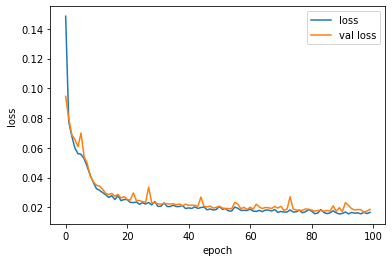

In [17]:
if mode == 'train':
    plt.figure(2111)
    plt.plot(train_history.history['loss'], label = 'loss')
    plt.plot(train_history.history['val_loss'], label = 'val loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

In [18]:
# trained_model = Model(inputs=encoder_inputs, outputs=ae_outputs, name='VAE')


In [19]:
# trained_model = Model(inputs=encoder_inputs, outputs=ae_outputs, name='VAE')
model.load_weights(weights_filepath)
model.summary()
# model.layers[-2]

Model: "AE"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Field (InputLayer)             [(None, 128, 128, 1  0           []                               
                                28, 1)]                                                           
                                                                                                  
 encoder (Functional)           (None, 8)            2545704     ['Field[0][0]']                  
                                                                                                  
 model (Functional)             (None, 128, 128, 12  450273      ['encoder[0][0]']                
                                8, 1)                                                             
                                                                                                 

In [20]:
# model.layers[-4].output

In [21]:
trained_encoder = Model(model.input, model.layers[1].output)

decoder_input = Input(shape=(latent_dim,))
trained_decoder = Model(decoder_input, model.layers[-1](decoder_input))

trained_encoder.summary()
# trained_decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Field (InputLayer)          [(None, 128, 128, 128, 1  0         
                             )]                                  
                                                                 
 conv3d (Conv3D)             (None, 128, 128, 128, 12  3584      
                             8)                                  
                                                                 
 conv3d_1 (Conv3D)           (None, 32, 32, 32, 64)    221248    
                                                                 
 conv3d_2 (Conv3D)           (None, 16, 16, 16, 64)    110656    
                                                                 
 conv3d_3 (Conv3D)           (None, 8, 8, 8, 64)       110656    
                                                                 
 flatten (Flatten)           (None, 32768)             0   

In [22]:
# test_img.shape, trained_encoder.predict(test_img).shape # want (6, 16)

In [23]:
num_test = 6
test_img = test_images[0:num_test]
pred_img = model.predict(test_img)
test_r2 = test_radii[0:num_test, 0]**2 + test_radii[0:num_test, 1]**2 + test_radii[0:num_test, 2]**2
print(test_img.shape, pred_img.shape, test_r2.shape)

(6, 128, 128, 128) (6, 128, 128, 128, 1) (6,)


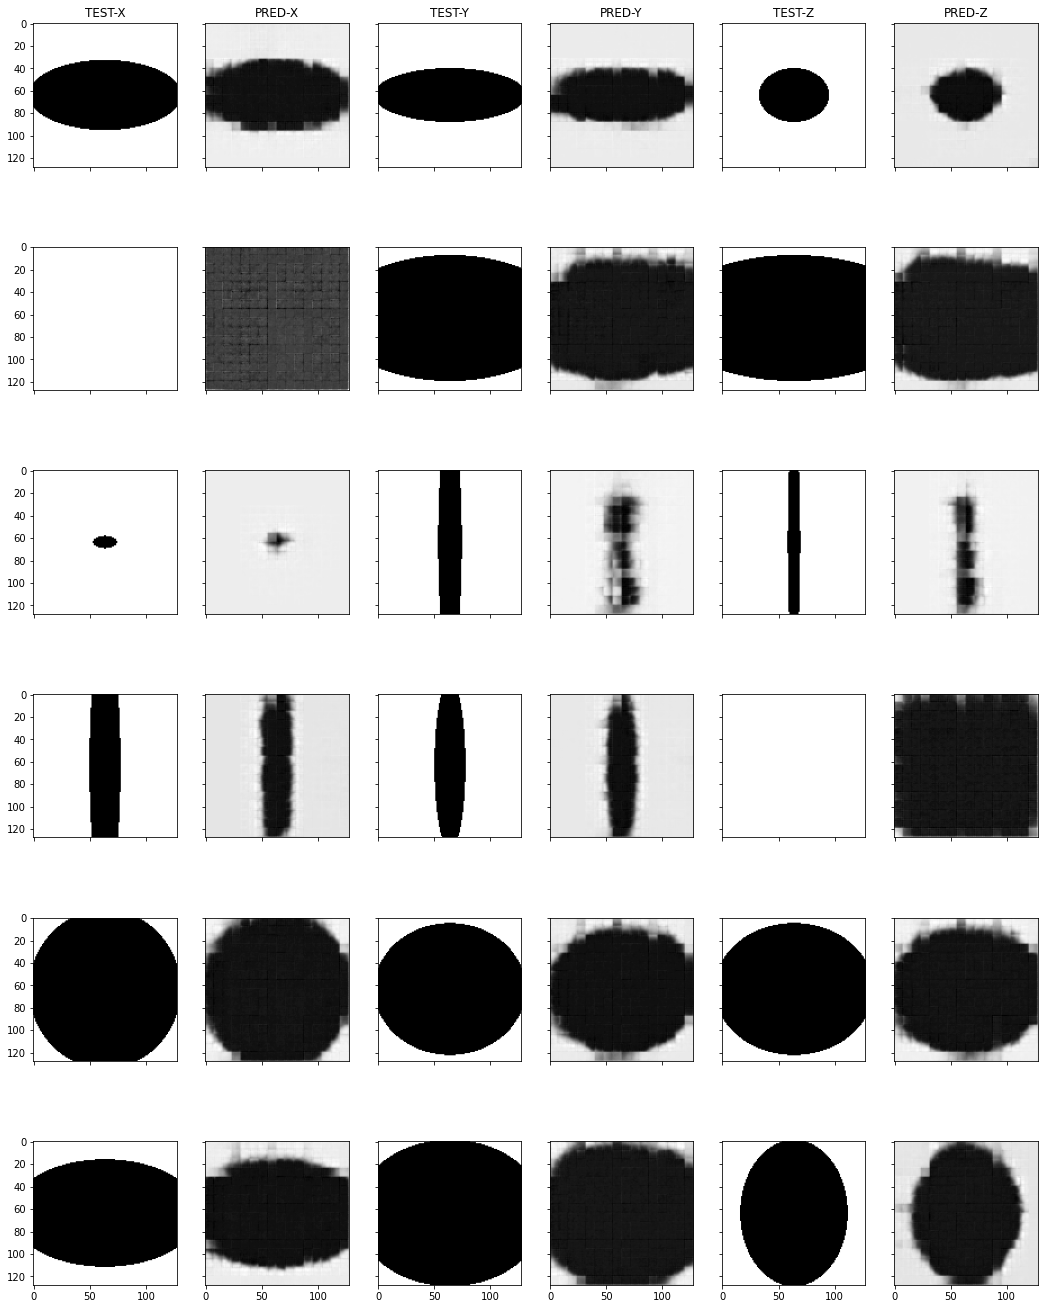

In [24]:

f, a = plt.subplots(test_img.shape[0], 6, figsize = (18, 4*test_img.shape[0]), sharey=True, sharex=True)

for img_ind in range(test_img.shape[0]):
    
    a[img_ind, 0].imshow(test_img[img_ind, 64, :, :], cmap='gray_r')
    a[img_ind, 1].imshow(pred_img[img_ind, 64, :, :], cmap='gray_r')
    
    a[img_ind, 2].imshow(test_img[img_ind, :, 64, :], cmap='gray_r')
    a[img_ind, 3].imshow(pred_img[img_ind, :, 64, :], cmap='gray_r')
    
    
    a[img_ind, 4].imshow(test_img[img_ind, :, :, 64], cmap='gray_r')
    a[img_ind, 5].imshow(pred_img[img_ind, :, :, 64], cmap='gray_r')

a[0, 0].set_title('TEST-X')
a[0, 1].set_title('PRED-X')

a[0, 2].set_title('TEST-Y')
a[0, 3].set_title('PRED-Y')

a[0, 4].set_title('TEST-Z')
a[0, 5].set_title('PRED-Z')

plt.show()

In [25]:
test_encoded = encoder.predict(test_img)
test_encoded2 = trained_encoder.predict(test_img)
print(test_img.shape, np.array(test_encoded).shape, test_r2.shape, np.array(test_encoded2).shape)

(6, 128, 128, 128) (6, 8) (6,) (6, 8)


In [ ]:
num_test = 400

test_encoded_arr = np.zeros(shape=(latent_dim, num_test))
for test_ind in range(num_test):
    test_img = train_images[test_ind]
    test_encoded = trained_encoder.predict(test_img[np.newaxis])
    test_encoded_arr[:, test_ind] = test_encoded
                            
test_r2 = train_radii[0:num_test, 0]**2 + train_radii[0:num_test, 1]**2 + train_radii[0:num_test, 2]**2


reducer = umap.UMAP(random_state=42)
reducer.fit(test_encoded_arr.T)

embedding = reducer.transform(test_encoded_arr.T)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(embedding == reducer.embedding_))
embedding.shape


plt.figure( figsize = (8, 7))
plt.scatter(embedding[:, 0], embedding[:, 1], c= np.log10(test_r2), cmap='Spectral', s=70)
plt.gca().set_aspect('equal', 'datalim')
# plt.colorbar(boundaries=np.arange(3)-0.5).set_ticks(np.arange(2))
cbar = plt.colorbar()
cbar.set_label(r'$log(R^2)$', rotation=270, fontsize = 20, labelpad=20)
plt.title('UMAP projection of the encoded space \n loaded weights', fontsize=15);